In [167]:
import mrob
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

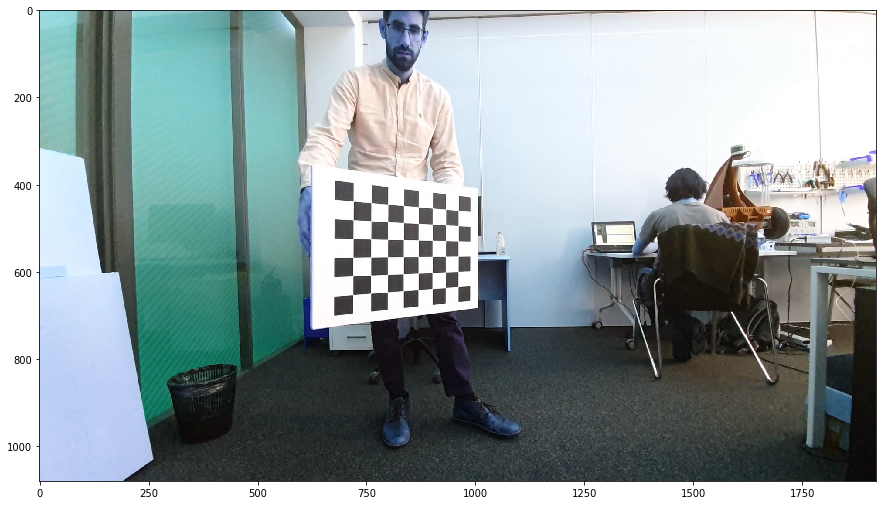

In [168]:
#load data:
file_path = "/home/gonzalo/mnt/bandeja-sequence/temp_gonzalo/chess1.png"
#file_path = "/home/gonzalo/mnt/bandeja-sequence/temp_gonzalo/people2.png"
img = cv.imread(file_path)
plt.figure(figsize=(15, 15))
plt.imshow(img)

{'intrinsics': array([[727.93162815,   0.        , 964.50039906],
       [  0.        , 731.18518186, 551.53912623],
       [  0.        ,   0.        ,   1.        ]]), 'dist_coeff': array([[ 0.00237778, -0.01595568,  0.00023181, -0.00137306,  0.        ]]), 'undist_intrinsics': array([[618.53674316,   0.        , 951.58637947],
       [  0.        , 621.05401611, 557.46108028],
       [  0.        ,   0.        ,   1.        ]])}


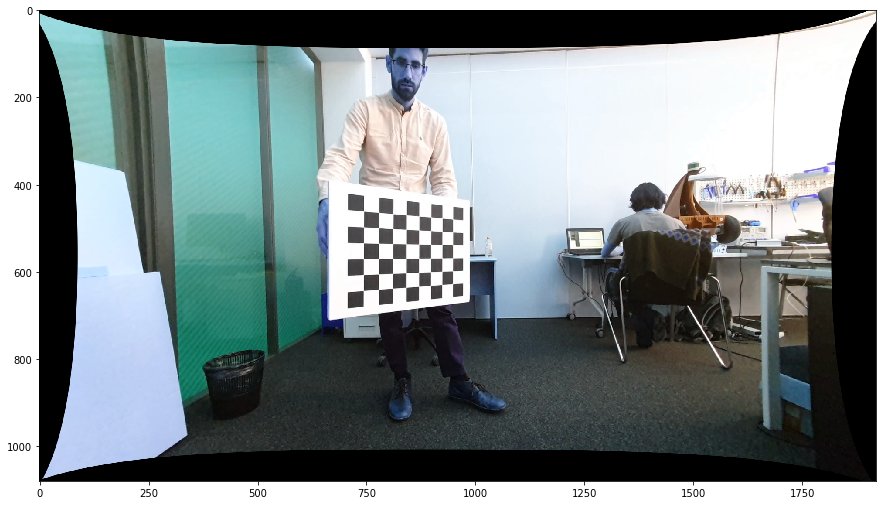

In [169]:
calib_intrinsincs = np.load('calib_output/s102_intrinsics.npy', allow_pickle=True).item()
intrinsics = calib_intrinsincs['intrinsics']
dist_coeff = calib_intrinsincs['dist_coeff']
undist_intrinsics = calib_intrinsincs['undist_intrinsics']
print(calib_intrinsincs)
undist_img = cv.undistort(img, intrinsics, dist_coeff, None, undist_intrinsics)
plt.figure(figsize=(15, 15))
plt.imshow(undist_img)

(1080, 1920) (89, 87, 1729, 921)


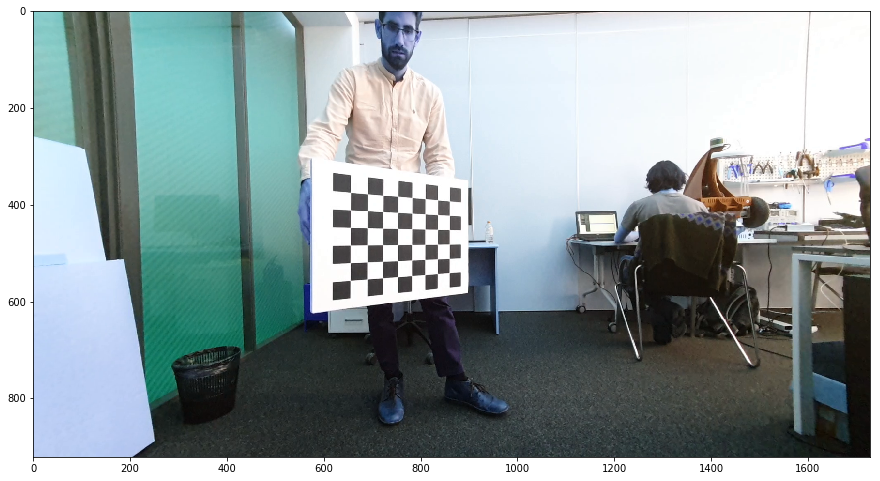

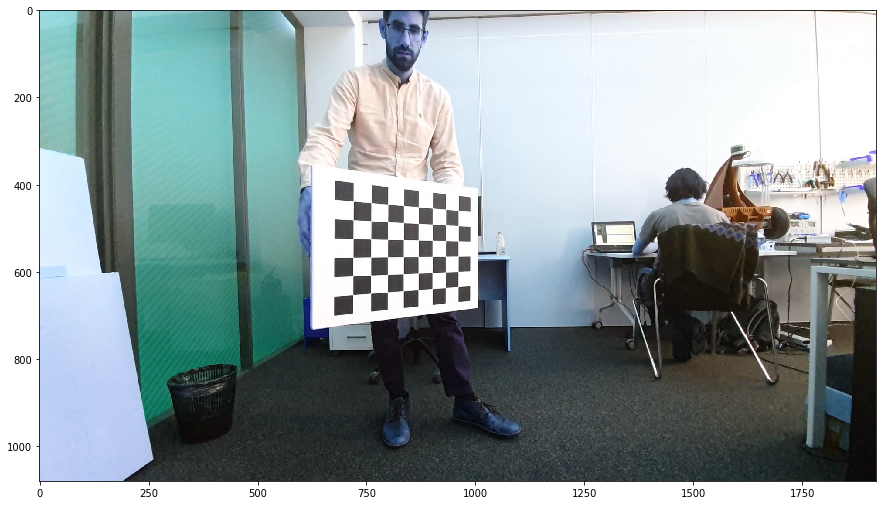

In [170]:
#crop the image
h, w = img.shape[:2]
_, roi = cv.getOptimalNewCameraMatrix(intrinsics, dist_coeff, (w,h), 1, (w,h))
print(img.shape[:2],roi)
x, y, w, h = roi
undist_img = undist_img[y:y+h, x:x+w]
plt.figure(figsize=(15, 15))
plt.imshow(undist_img)
plt.figure(figsize=(15, 15))
plt.imshow(img)

# Load PC

In [171]:
import open3d as o3d
file_path = "/home/gonzalo/mnt/bandeja-sequence/temp_gonzalo/chess1.pcd"
#file_path = "/home/gonzalo/mnt/bandeja-sequence/temp_gonzalo/people2.pcd"
pcd = o3d.io.read_point_cloud(file_path)
T = np.array([[ 0.99696022, -0.00162089,  0.07789536, -0.2221667 ],
               [-0.00699329,  0.99388633,  0.11018643,  0.03609816],
               [-0.07759773, -0.11039623,  0.99085381,  0.05171391],
               [ 0.        ,  0.        ,  0.        ,  1.        ]])
T2 = mrob.geometry.SE3().T()
T2[0,3]=-0.28
T2[1,3]=0.01
T2[2,3]=0.05
print(T2)
T[0,3]=-0.28
pcd.transform(T2)
mesh_box = o3d.geometry.TriangleMesh.create_box(width=0.1,
                                                    height=0.1,
                                                    depth=0.1)
#o3d.visualization.draw_geometries([pcd,mesh_box])

[[ 1.    0.    0.   -0.28]
 [ 0.    1.    0.    0.01]
 [ 0.    0.    1.    0.05]
 [ 0.    0.    0.    1.  ]]


## project point cloud into depth

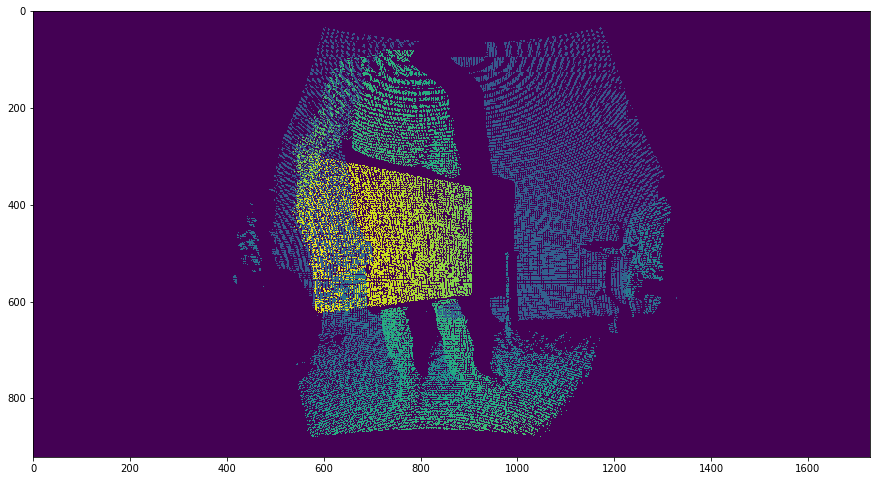

In [172]:
# iterate points and project them into
I = np.zeros(undist_img.shape[:2],np.float32) #very far away, TODO which one is the invalid number?
I2 = np.zeros(undist_img.shape,np.float32)
for P in pcd.points:
    d = np.linalg.norm(P)
    P = P/P[2]
    p = undist_intrinsics@P
    x, y = int(np.round(p[0])), int(np.round(p[1]))
    if x >= 0 and x < w and y >= 0 and y < h:
        I[y,x]=1/d
        I2[y,x,0] = 1/d
I = I/np.max(I)
I2 = I2/np.max(I2)
plt.figure(figsize=(15, 15))
plt.imshow(I)

In [135]:
# convert images to o3d standard
#rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(undist_img, I)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


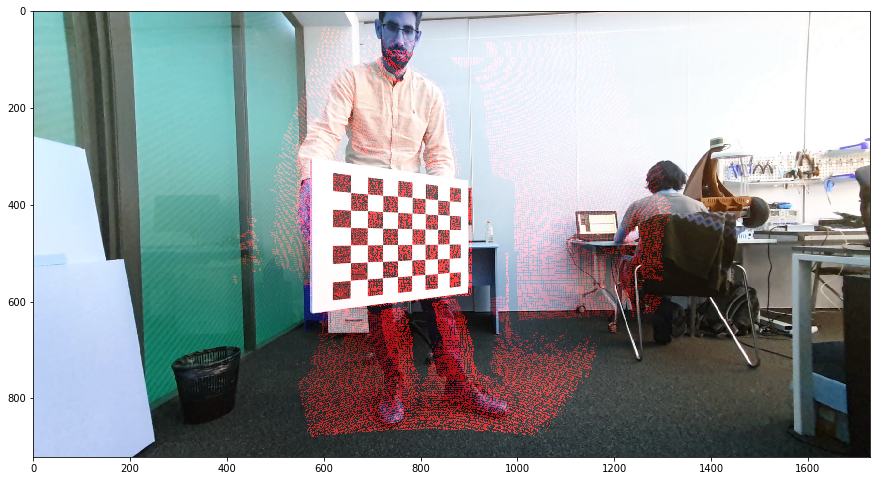

In [173]:
# other option, plot both images with transparencies?
gray = cv.cvtColor(undist_img, cv.COLOR_BGR2GRAY)
plt.figure(figsize=(15, 15))
#ji = cv.addWeighted(I, 0.5, gray, 0.5, 0.0) #does not work
#plt.imshow(gray*0.01 + I)
plt.imshow(I2+undist_img/255)
#cv.imwrite('im1.jpg', I2+undist_img/255 )